In [13]:
!pip install transformers
!pip install datasets

import time
import os
from argparse import Namespace
import random
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import pandas as pd
from tqdm import tqdm

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

# Setup logging
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.WARN)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
from datasets import load_dataset

dataset = load_dataset("klue", "sts")

dataset

02/16/2023 03:37:54 - WARNING - datasets.builder -   Found cached dataset klue (/Users/hwangtaegyeong/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})

In [15]:
dataset = dataset.flatten()
dataset = dataset.rename_column('labels.real-label','labels')

In [4]:
# argment setting
model_checkpoint = "bert-base-multilingual-cased"
batch_size_per_device = 32
max_length = 256
n_epochs = 3
warmup_ratio = .2
lr = 5e-5

In [5]:
# load model&tokenizerx
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint, use_fast=True)

In [6]:
def preprocess_function(examples):
    return tokenizer(examples['sentence1'], examples['sentence2'],
                     truncation=True, max_length=max_length, padding=True)

In [7]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
encoded_dataset

[[101,
  9461,
  22333,
  9619,
  72087,
  9737,
  12310,
  9471,
  11664,
  9641,
  30134,
  15387,
  48556,
  10459,
  9321,
  12508,
  35506,
  9461,
  22333,
  58303,
  48345,
  119,
  102,
  9461,
  118963,
  14040,
  31928,
  10459,
  9619,
  72087,
  9471,
  14153,
  9737,
  10622,
  9460,
  40523,
  48556,
  10459,
  9069,
  37824,
  15387,
  9321,
  12508,
  35506,
  9461,
  118963,
  14040,
  31928,
  58303,
  48345,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  9619,
  30134,
  25549,
  19855,
  9678,
  12945,
  33727,
  8863,
  14646,
  217,
  9328,
  14523,
  217

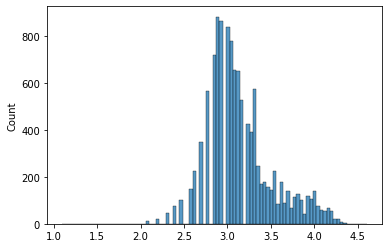

log value : 4.28909157902064
original value : 72.9002143267545


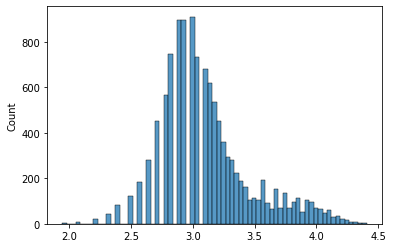

log value : 4.223566831737898
original value : 68.27658156623471


In [93]:
# 훈련셋의 앞부분 출력
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in encoded_dataset['train']['sentence1']]
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

tokenizer_len = [len(tokenizer(s)['input_ids']) for s in encoded_dataset['train']['sentence2']]
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

In [94]:
len_dataset = len(encoded_dataset['train'])
len_validset = len(encoded_dataset['validation'])

print('#train =', len_dataset,
      '#valid =', len_validset
      )

total_batch_size = batch_size_per_device * torch.cuda.device_count()
n_total_iterations = int(len_dataset / total_batch_size * n_epochs)
n_warmup_steps = int(n_total_iterations * warmup_ratio)

print(
        '#total_iters =', n_total_iterations,
        '#warmup_iters =', n_warmup_steps,
      )

#train = 11668 #valid = 519
#total_iters = 1093 #warmup_iters = 218


In [95]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [96]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)
model.to(device)
#model.cuda()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_ca

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [109]:
import os

model_name = model_checkpoint.split("/")[-1]
output_dir = os.path.join("sts")
logging_dir = os.path.join(output_dir, 'logs')
args = TrainingArguments(
    # checkpoint
    output_dir=output_dir,

    # Model Save & Load
    save_strategy = "epoch", # 'steps'
    load_best_model_at_end=True,

    # Dataset
    num_train_epochs=n_epochs,
    per_device_train_batch_size= batch_size_per_device,
    per_device_eval_batch_size= batch_size_per_device,
    
    # Optimizer
    learning_rate=lr, # 5e-5
    weight_decay=0.01,  # 0
    warmup_steps=n_warmup_steps,

    # Resularization
    # max_grad_norm = 1.0,
    # label_smoothing_factor=0.1,

    # Use mixed precision
    # mixed precision mode
    fp16=False,                                 
    #fp16_opt_level="02",  

    # Evaluation 
    metric_for_best_model='eval_pearsonr',
    evaluation_strategy = "epoch",

    # Logging
    logging_dir=logging_dir,

    # Randomness
    seed=42,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [110]:
# datasets 라이브러리에서 제공하는 Evaluation metric의 리스트를 확인합니다.
from datasets import list_metrics, load_metric
metrics_list = list_metrics()
len(metrics_list)
print(', '.join(metric for metric in metrics_list))

accuracy, bertscore, bleu, bleurt, brier_score, cer, character, charcut_mt, chrf, code_eval, comet, competition_math, coval, cuad, exact_match, f1, frugalscore, glue, google_bleu, indic_glue, mae, mahalanobis, mape, mase, matthews_correlation, mauve, mean_iou, meteor, mse, nist_mt, pearsonr, perplexity, poseval, precision, recall, rl_reliability, roc_auc, rouge, sacrebleu, sari, seqeval, smape, spearmanr, squad, squad_v2, super_glue, ter, trec_eval, wer, wiki_split, xnli, xtreme_s, BucketHeadP65/confusion_matrix, BucketHeadP65/roc_curve, Drunper/metrica_tesi, Felipehonorato/my_metric, GMFTBY/dailydialog_evaluate, GMFTBY/dailydialogevaluate, JP-SystemsX/nDCG, Josh98/nl2bash_m, KevinSpaghetti/accuracyk, NCSOFT/harim_plus, NikitaMartynov/spell-check-metric, NimaBoscarino/weat, Ochiroo/rouge_mn, Vertaix/vendiscore, Viona/infolm, Vlasta/pr_auc, abdusah/aradiawer, abidlabs/mean_iou, abidlabs/mean_iou2, angelina-wang/directional_bias_amplification, anz2/iliauniiccocrevaluation, bstrai/classif

In [111]:
# YNAT의 metric은 F1 score를 사용합니다.
metric_pearsonr = load_metric('pearsonr')

In [115]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    return metric_pearsonr.compute(predictions=predictions,
                                  references=labels)

In [116]:
from transformers import default_data_collator
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [117]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: labels.label, source, guid, sentence2, labels.binary-label, sentence1. If labels.label, source, guid, sentence2, labels.binary-label, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 11668
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1095
  Number of trainable parameters = 177854209


Epoch,Training Loss,Validation Loss,Pearsonr
1,No log,0.661094,0.836880
2,0.108900,0.656406,0.842024
3,0.084100,0.613649,0.850463


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: labels.label, source, guid, sentence2, labels.binary-label, sentence1. If labels.label, source, guid, sentence2, labels.binary-label, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 519
  Batch size = 32
Saving model checkpoint to sts/checkpoint-365
Configuration saved in sts/checkpoint-365/config.json
Model weights saved in sts/checkpoint-365/pytorch_model.bin
tokenizer config file saved in sts/checkpoint-365/tokenizer_config.json
Special tokens file saved in sts/checkpoint-365/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: labels.label, source, guid, sentence2, labels.binary-label, sentence1. If labels.label, sour

TrainOutput(global_step=1095, training_loss=0.09358259357818186, metrics={'train_runtime': 962.3095, 'train_samples_per_second': 36.375, 'train_steps_per_second': 1.138, 'total_flos': 2794682981934432.0, 'train_loss': 0.09358259357818186, 'epoch': 3.0})

In [118]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: labels.label, source, guid, sentence2, labels.binary-label, sentence1. If labels.label, source, guid, sentence2, labels.binary-label, sentence1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 519
  Batch size = 32


{'eval_loss': 0.6136492490768433,
 'eval_pearsonr': 0.8504634559426292,
 'eval_runtime': 4.6831,
 'eval_samples_per_second': 110.825,
 'eval_steps_per_second': 3.63,
 'epoch': 3.0}

In [121]:
trainer.save_model('./checkpoint')

Saving model checkpoint to ./checkpoint
Configuration saved in ./checkpoint/config.json
Model weights saved in ./checkpoint/pytorch_model.bin
tokenizer config file saved in ./checkpoint/tokenizer_config.json
Special tokens file saved in ./checkpoint/special_tokens_map.json


In [120]:
sentence1 = "안녕하세요"
sentence2 = "안녕하세요"

test = torch.tensor([tokenizer.encode(sentence1, sentence2)]).to(device)

with torch.no_grad():
  preds = model(test).logits.cpu()

result = preds

print(preds[:][0])

tensor([3.1671])
